In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger


In [11]:
import zipfile
import os

# Define your ZIP file name
zip_file = "archive.zip"  # Change this to your actual ZIP file name

# Extract it to a folder with the same name
extract_folder = zip_file.replace(".zip", "")  
# os.makedirs(extract_folder, exist_ok=True)

# # Extract files
# with zipfile.ZipFile(zip_file, "r") as zip_ref:
     # zip_ref.extractall(extract_folder)

print(f"Extracted to: {extract_folder}")


Extracted to: archive


In [12]:
extract_folder ="archive/flowers" 
basic_transformer = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5) ,
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ]
)

image_folder= ImageFolder( extract_folder , transform= basic_transformer)
len(image_folder)

4317

In [ ]:
image_folder.classes

In [13]:
length= len(image_folder)
val_split_size=0.2
train_length= round(length*(1-val_split_size))
val_length = length- train_length
image_folder_train, image_folder_val = random_split(image_folder, [train_length, val_length])

In [14]:
train_dataloader = DataLoader(image_folder_train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(image_folder_val, batch_size=32, shuffle=False)
len(train_dataloader), len(val_dataloader)

(108, 27)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.671852].


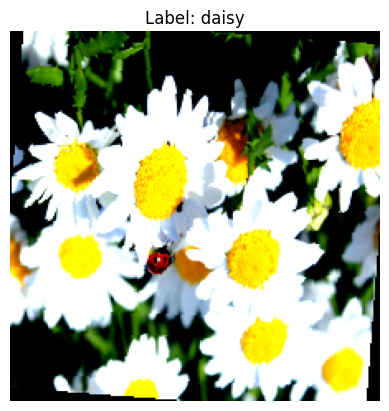

In [9]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(train_dataloader))

# Take the first image in the batch
img = images[0]
label = labels[0].item()

# Convert from tensor (C, H, W) to (H, W, C) and denormalize
img = img.permute(1, 2, 0) * 0.5 + 0.5  # scale back to [0,1]

plt.imshow(img.numpy())
plt.title(f'Label: {image_folder.classes[label]}')
plt.axis('off')
plt.show()


In [6]:
from pl_bolts.models.self_supervised import SimCLR


In [ ]:
class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        #self.backbone= models.resnet50(pretrained=True)
        #self.finetune_layer= torch.nn.Linear(self.backbone.fc.out_features, num_classes)

        # we have a pretrained simclr model that knows how to generate feature map 
        # so that similar images have similar feature maps and different images have different feature maps 
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

        #feature extractor
        self.backbone=simclr
        #classifier for our dataset
        self.finetune_layer= torch.nn.Linear(2048, num_classes)
        
    def training_step(self, batch):
        img, label=batch
        
        with torch.no_grad():
            features = self.backbone(img)
        
        preds=self.finetune_layer(features)
        
        loss= cross_entropy(preds, label)
        accuracy_score= accuracy(preds, label, task='multiclass',num_classes= self.hparams.num_classes)
        
        metrics = {'train_loss':loss, 'train_acc':accuracy_score}
        self.log_dict(metrics, on_step=False, on_epoch= True, prog_bar=True, logger=True)
        
        return loss
    
    def validation_step(self, batch):
        
        img, label = batch
        
        features = self.backbone(img)
        preds= self.finetune_layer(features)
        
        loss= cross_entropy(preds, label)
        accuracy_score= accuracy(preds, label, task='multiclass', num_classes=self.hparams.num_classes)
        
        metrics = {'val_loss': loss, 'val_acc': accuracy_score}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer= Adam(self.parameters(), lr= self.hparams.lr)
        return optimizer
        

In [16]:
logger = TensorBoardLogger('./logs', name='ssl_log')

In [21]:
classifier= FlowerImageClassifier()
trainer= pl.Trainer(max_epochs= 20, logger=logger,gpus=1)
trainer.fit(classifier, train_dataloaders= train_dataloader)

Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file c:\I\gans-class-example\ssl\https:\pl-bolts-weights.s3.us-east-2.amazonaws.com\simclr\bolts_simclr_imagenet\simclr_imagenet.ckpt`
c:\I\gans-class-example\env\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\I\gans-class-example\env\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/